In [287]:
import serial, struct, time, datetime, os, glob, errno
import numpy as np

In [328]:
from matplotlib import pyplot as plt
%matplotlib notebook

In [329]:
ser = serial.Serial("/dev/ttyUSB2", baudrate=9600, stopbits=1, parity="N")

In [278]:
class UnexpectedDigitException(Exception):
    pass

In [308]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise


def read_one_measurement(n=16):
    ser.flushInput()
    fmt = "b"*n
    buf_size = struct.calcsize(fmt)
    line = ser.read(buf_size)
    unpacked = struct.unpack(fmt, line)
    return [d & 0b1111 for d in unpacked]

def find_measurement_end():
    for i in range(100):
        m = read_one_measurement(n=1)
        if (m[0]==13):
            return
    raise UnexpectedDigitException()


def process_torque_measurement(raw_measurement):

    unpacked = raw_measurement
    
#     print (("{:2d} "*16).format(*unpacked))
#     print (("{: >8d} "*16).format(*unpacked))
#     print (("{: >8b} "*16).format(*unpacked))
#     print (("{: >8x} "*16).format(*unpacked))

    if unpacked[1] != 4: raise UnexpectedDigitException()
    if unpacked[2] != 1: raise UnexpectedDigitException()
    if unpacked[3] != 8: raise UnexpectedDigitException("check torque sensor is connected")
    units = unpacked[4]
    if not 1 <= units <= 3: raise UnexpectedDigitException("check torque sensor is connected")
    units_dict = {
        1 : "Kg_cm",
        2 : "LB_inch",
        3 : "N_cm"}
    units = units_dict[units]
    polarity = unpacked[5]
    if not polarity in [0, 1]: raise UnexpectedDigitException()
    decimal_point_position = unpacked[6]
    if not decimal_point_position in range(4): raise UnexpectedDigitException()
#     print (decimal_point_position)
    digits = unpacked[7:15]
    digits_s = ("{}"*len(digits)).format(*digits)
    measurement = float(digits_s)
    measurement *= (-1)**polarity
    measurement /= 10**decimal_point_position
    if unpacked[15] != 13: raise UnexpectedDigitException("message got corrupted")
    return measurement, units
    

def process_force_measurement(raw_measurement):

    unpacked = raw_measurement
    
#     print (("{:2d} "*16).format(*unpacked))
#     print (("{: >8d} "*16).format(*unpacked))
#     print (("{: >8b} "*16).format(*unpacked))
#     print (("{: >8x} "*16).format(*unpacked))

    if unpacked[1] != 4: raise UnexpectedDigitException()
    if unpacked[2] != 1: raise UnexpectedDigitException()
    if unpacked[3] != 5: raise UnexpectedDigitException("check force sensor is connected")
    units = unpacked[4]
    if not 5 <= units <= 9: raise UnexpectedDigitException("check force sensor is connected")
    units_dict = {
        5 : "Kg",
        6 : "LB",
        7 : "g",
        8 : "oz",
        9 : "N"
    }
    units = units_dict[units]
    polarity = unpacked[5]
    if not polarity in [0, 1]: raise UnexpectedDigitException()
    decimal_point_position = unpacked[6]
    if not decimal_point_position in range(4): raise UnexpectedDigitException()
#     print (decimal_point_position)
    digits = unpacked[7:15]
    digits_s = ("{}"*len(digits)).format(*digits)
    measurement = float(digits_s)
    measurement *= (-1)**polarity
    measurement /= 10**decimal_point_position    
    if unpacked[15] != 13: raise UnexpectedDigitException("message got corrupted")
    return measurement, units 
    


    

In [309]:
def aquire_data(name):
    try:
        force_measurements = []
        torque_measurements = []
        t = time.time()
        while True:
            raw_measurement = read_one_measurement()
            t_now = time.time() - t
            try:
                force_measurements.append((*process_force_measurement(raw_measurement), t_now))
            except UnexpectedDigitException:
                try:
                    torque_measurements.append((*process_torque_measurement(raw_measurement), t_now))
                except UnexpectedDigitException:
                    print ("One measurement failed")
                    find_measurement_end()
    except KeyboardInterrupt:
    #     print (force_measurements, torque_measurements)
        mkdir_p("data_"+ name)
        force_measurements = np.array(force_measurements)
        torque_measurements = np.array(torque_measurements)
        now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        np.savetxt("data_" + name + "/" + now + "_force.csv", force_measurements, fmt="%s")
        np.savetxt("data_" + name + "/" + now + "_torque.csv", torque_measurements, fmt="%s")
        print ("Stopped, saved")

In [310]:
aquire_data("Dima")

Stopped, saved


In [300]:
force_measurements.T

array([['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
       ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
        'N', 'N', 'N', 'N', 'N'],
       ['0.9032585620880127', '1.4824209213256836', '2.066373348236084',
        '2.64544677734375', '3.241450786590576', '3.8290576934814453',
        '4.4116809368133545', '5.595254421234131', '6.17788290977478',
        '6.759303569793701', '7.340975522994995', '7.921292066574097',
        '9.084412813186646', '9.666915655136108', '10.250897407531738',
        '10.830011367797852', '11.410307168960571', '11.993088722229004']], 
      dtype='<U32')

data_Dima/2017-10-10_12:33:59_force.csv
data_Dima/2017-10-10_12:33:59_torque.csv


<IPython.core.display.Javascript object>


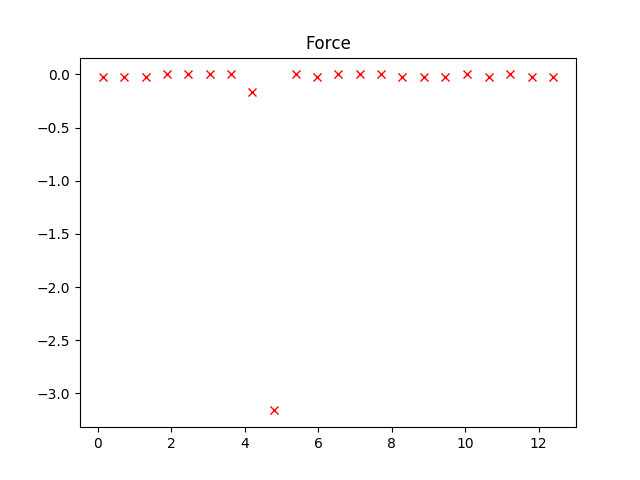

<IPython.core.display.Javascript object>


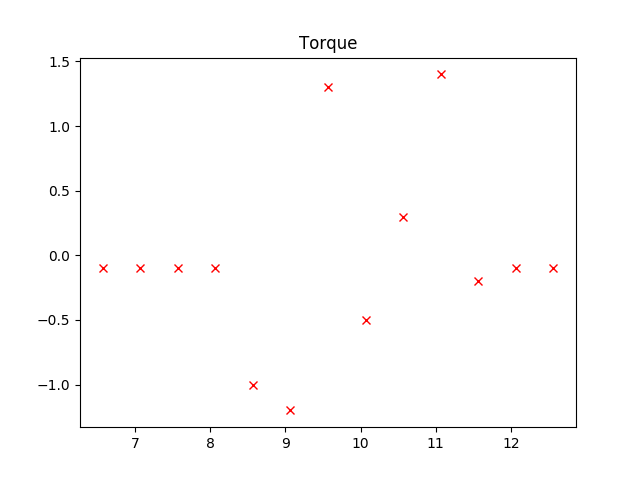

In [332]:
for data_directory in glob.glob("data_*"):
    for force_file in glob.glob(data_directory + "/*_force.csv"):
        print (force_file)
        torque_file = force_file[:-9] + "torque.csv"
        print(torque_file)
        force = np.loadtxt(force_file, dtype='S')
        torque = np.loadtxt(torque_file, dtype='S')
        force_f = force.T[0].astype(np.float)
        force_t = force.T[2].astype(np.float)
        assert (force.T[1]==force.T[1,0]).all(), "Some measurements have different units"
        torque_f = torque.T[0].astype(np.float)
        torque_t = torque.T[2].astype(np.float)
        assert (torque.T[1]==torque.T[1,0]).all(), "Some measurements have different units"
        plt.figure()
        plt.title("Force")
        plt.plot(force_t, force_f, 'rx')
        plt.figure()
        plt.title("Torque")
        plt.plot(torque_t, torque_f, 'rx')
        